<h2>Training B</h2>
<br>
<p><b>Goal of this file:</b> storing data from sensors would be useless if we don't have the context of what are the reasons of that data. So in this file we want to create and train a neural network model in order to provide context to the sensor readings, enabling our product to determine which actions lead to variations in the observed values.</p>

<br>
<p>To achieve this, we have created a CSV file that contains all the data derived by sensor readings during a week. Every minute, the sensors retrieve our parameters (number of people, the "state" of every window and every shutter, etc.), and it associates the "labels": Temperature, CO2, Pressure, Humidity.</p>

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import History, EarlyStopping
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

<p>First of all, we need to adjust data in order to be trainable by the Neural Network</p>

In [33]:
data = pd.read_csv('datasets/dataset.csv')

# Convert time to minutes from midnight and extract month from date
# data['time'] = pd.to_datetime(data['time']).dt.hour * 60 + pd.to_datetime(data['time']).dt.minute
# data['date'] = pd.to_datetime(data['date']).dt.month
data['date'] = np.array(pd.to_datetime(data['date']).dt.month)[0]
data['time'] = np.array(pd.to_datetime(data['time'].tail(1), format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['time'].tail(1), format='%H:%M:%S').dt.minute)[0]

features = data.drop(columns=['window1_tg', 'window2_tg', 'window3_tg', 'window4_tg', 'shutter1_tg', 'shutter2_tg', 'shutter3_tg', 'shutter4_tg'])
targets = data[['window1_tg', 'window2_tg', 'window3_tg', 'window4_tg', 'shutter1_tg', 'shutter2_tg', 'shutter3_tg', 'shutter4_tg']]

# Normalize numerical features
numerical_features = features.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
features[numerical_features] = scaler.fit_transform(features[numerical_features])

# Encode categorical features
# encoder = OneHotEncoder()
# categorical_features = ['date']  # Add other categorical feature names if necessary
# features_encoded = encoder.fit_transform(data[categorical_features]).toarray()
# features_encoded_df = pd.DataFrame(features_encoded, columns=encoder.get_feature_names_out(categorical_features))
# features = pd.concat([features.drop(columns=categorical_features), features_encoded_df], axis=1)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

<p>Now it's time to actually train the model:</p>

In [34]:
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1], ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(targets.shape[1], activation='linear')  # Adjust the output layer to match the number of target variables
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

D:\projects\final_round\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4277 - val_loss: 0.0806
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0685 - val_loss: 0.0445
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0409 - val_loss: 0.0342
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0312 - val_loss: 0.0285
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261 - val_loss: 0.0253
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213 - val_loss: 0.0231
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - val_loss: 0.0214
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189 - val_loss: 0.0201
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - val_loss: 0.0187
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - val_loss: 0.0180
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0170
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - val_lo

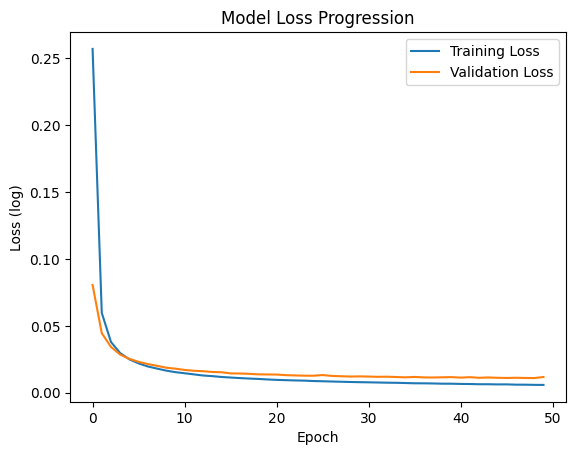

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error on Test Set: 0.010540121227652249


In [35]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.legend()
plt.show()

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

<p>After training, I save the model in a file</p>

In [36]:
model.save('my_model.keras')

In [37]:
model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[-0.01018974,  0.99533194, -0.01743402, ...,  0.7391992 ,
         0.6998871 ,  1.0020894 ],
       [ 0.20515163,  0.5521959 ,  0.5618719 , ...,  0.77521855,
         0.66400576,  0.16384318],
       [ 0.04834165,  0.923146  ,  0.07807123, ...,  0.826459  ,
         0.73452824,  0.4915528 ],
       ...,
       [ 0.01195847,  0.9916691 ,  0.00175701, ...,  0.8427546 ,
         0.6869313 ,  0.76929283],
       [-0.0048252 ,  0.99527407, -0.0182887 , ...,  0.9822118 ,
         1.0352442 ,  0.9889598 ],
       [ 0.01959757,  0.9826202 , -0.01198523, ...,  0.77864814,
         0.6690224 ,  0.86688054]], dtype=float32)